## Import modules

In [1]:
import numpy as np
import numpy.random as random
import pandas as pd
import scanpy as sc
import anndata
import matplotlib.pyplot as plt

In [2]:
import session_info
session_info.show()

In [3]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=200, color_map = 'RdPu',)

## Read in data

* batch_key: donor + nuclei_or_cells + kit_10x

In [5]:
adata = sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/scVI/RNA_foetal_scVI.h5ad')
adata

AnnData object with n_obs × n_vars = 372801 × 3343
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', '_scvi_labels'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: '_scvi', 'hvg'
    o

In [6]:
genename_column='gene_name_multiome-1'

In [7]:
# add previous annotation
prev=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/2JanCell2locObjectRaw.h5ad',backed='r')

adata.obs['2Jan_coarse_grain'] = prev.obs['coarse_grain'].reindex(adata.obs_names)
adata.obs['2Jan_mid_grain'] = prev.obs['mid_grain'].reindex(adata.obs_names)
adata.obs['2Jan_fine_grain'] = prev.obs['fine_grain'].reindex(adata.obs_names)

In [8]:
pd.crosstab(adata.obs['donor'],adata.obs['age'])

age,8w2d,8w5d,9w1d,9w3d,9w6d,11w3d,GA-6w3d,GA-7w4d,GA-8w1d,GA-9w,GA-9w4d,GA-10w4d,GA-11w2d,GA-11w3d,GA-12w5d,PCW-12w,PCW-13w,PCW-14w,PCW-15w,PCW-20w
donor,,,,,,,,,,,,,,,,,,,,
BRC2251,0,0,9651,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRC2252,7366,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRC2256,0,0,0,0,8525,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRC2260,0,0,0,0,0,8408,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRC2262,0,4749,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
BRC2263,0,0,0,5917,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
C82,0,0,0,0,0,0,0,0,0,0,0,0,0,611,0,0,0,0,0,0
C85,0,0,0,0,0,0,0,0,0,0,0,0,2808,0,0,0,0,0,0,0
C86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6567,0,0,0,0,0


## Clustering, UMAP, check modalities, QCs

In [9]:
%%time
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.2)
sc.tl.leiden(adata, resolution=1, key_added='leiden_scVI',)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:01:10)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:07:45)
running Leiden clustering
    finished: found 48 clusters and added
    'leiden_scVI', the cluster labels (adata.obs, categorical) (0:06:27)


CPU times: user 35min 35s, sys: 10min 35s, total: 46min 11s
Wall time: 15min 23s


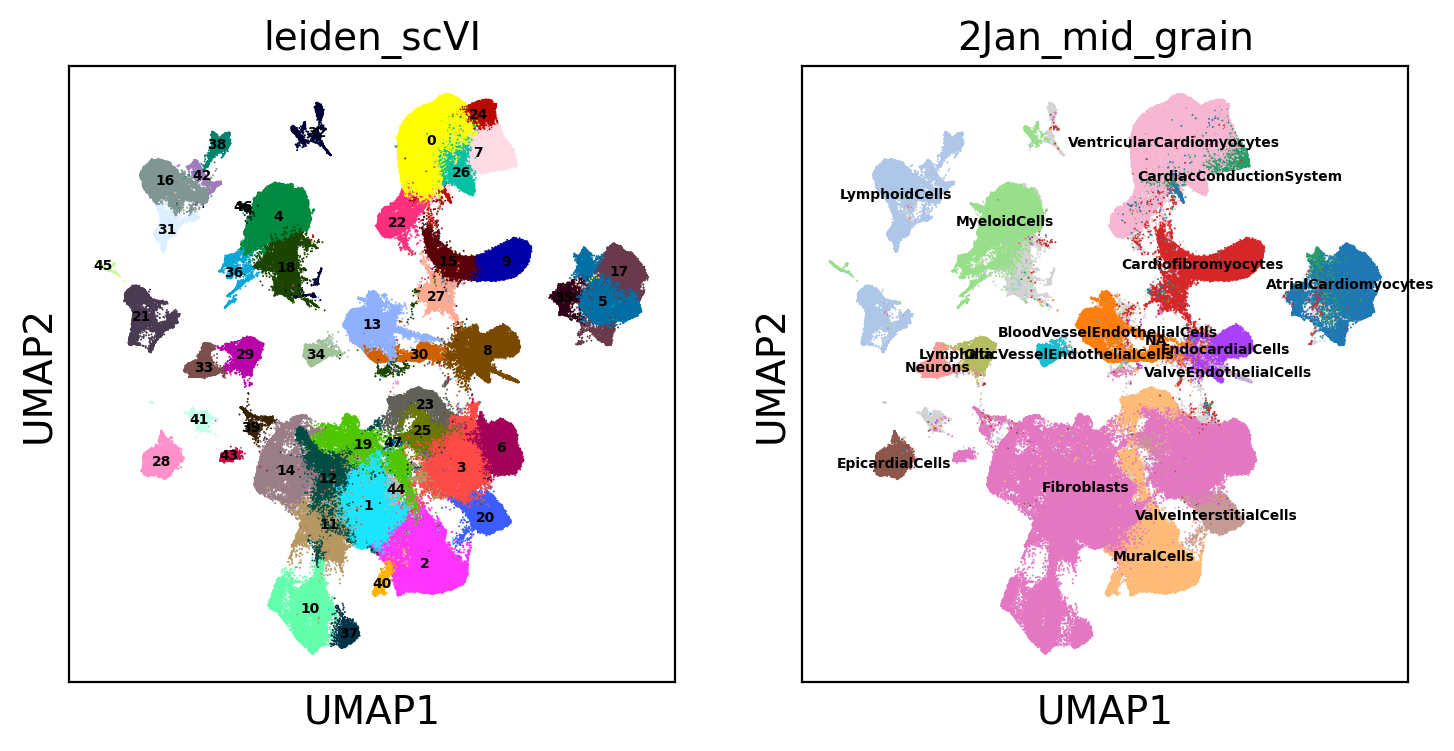

In [10]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['leiden_scVI','2Jan_mid_grain'], size=2, wspace=0.1, legend_loc='on data', legend_fontsize=5)

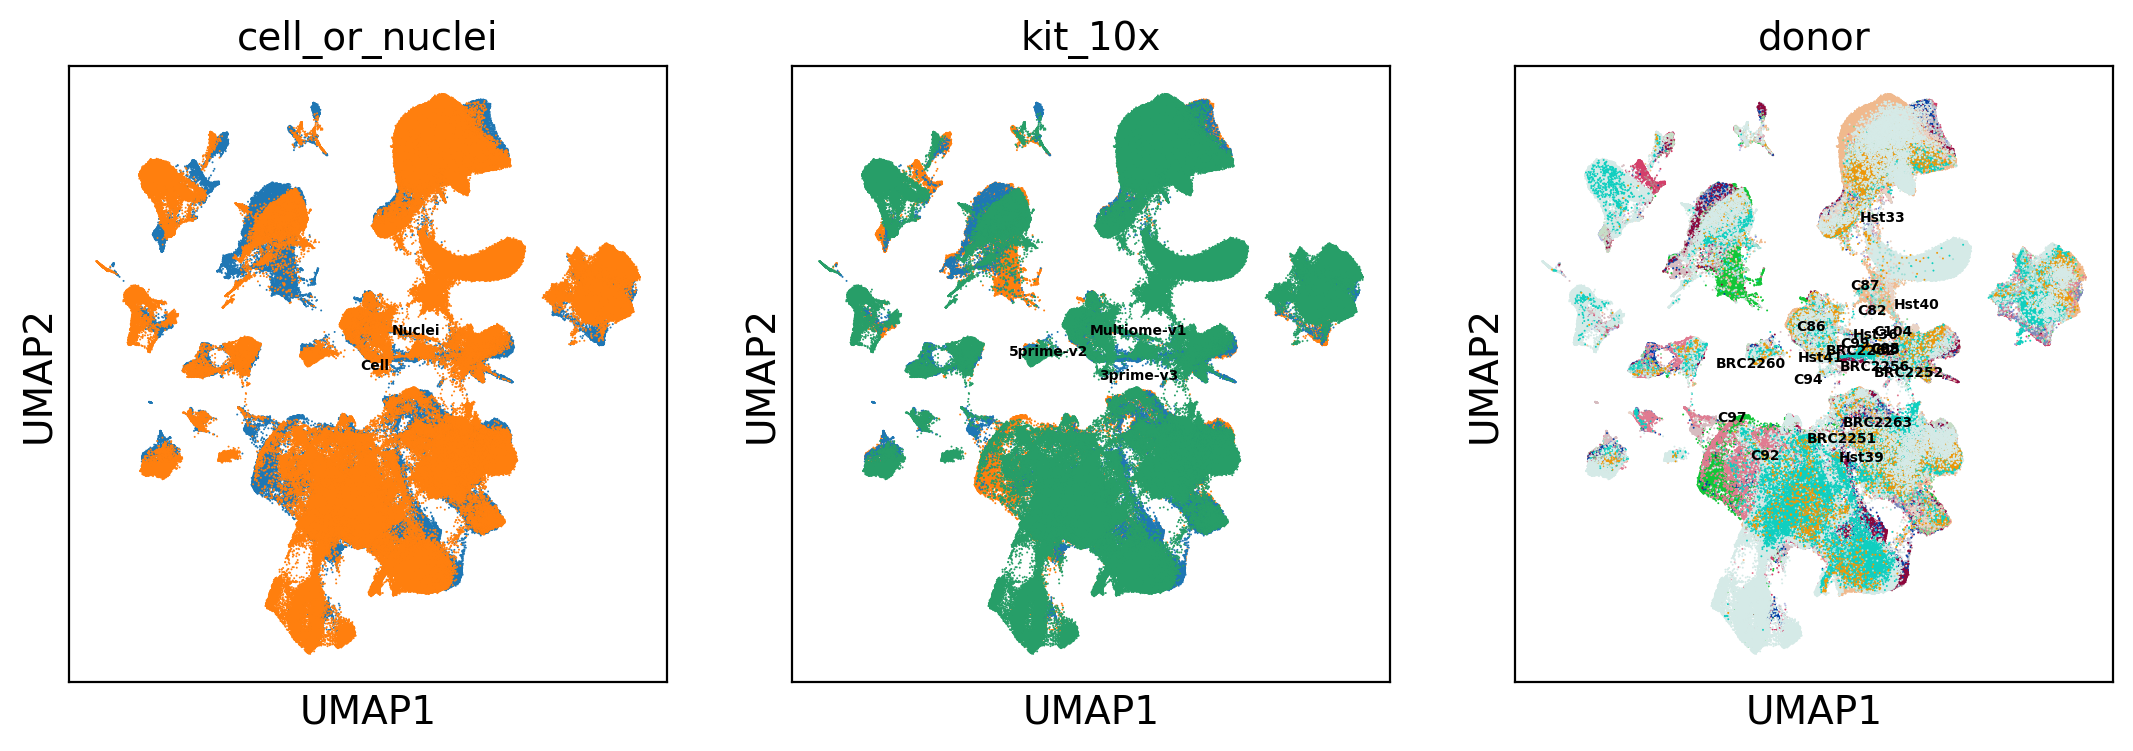

In [25]:
sc.settings.set_figure_params(dpi=200, facecolor='white', color_map = 'RdPu',)
sc.pl.umap(adata, color=['cell_or_nuclei','kit_10x','donor'], size=2, wspace=0.1, legend_loc='on data', legend_fontsize=5)

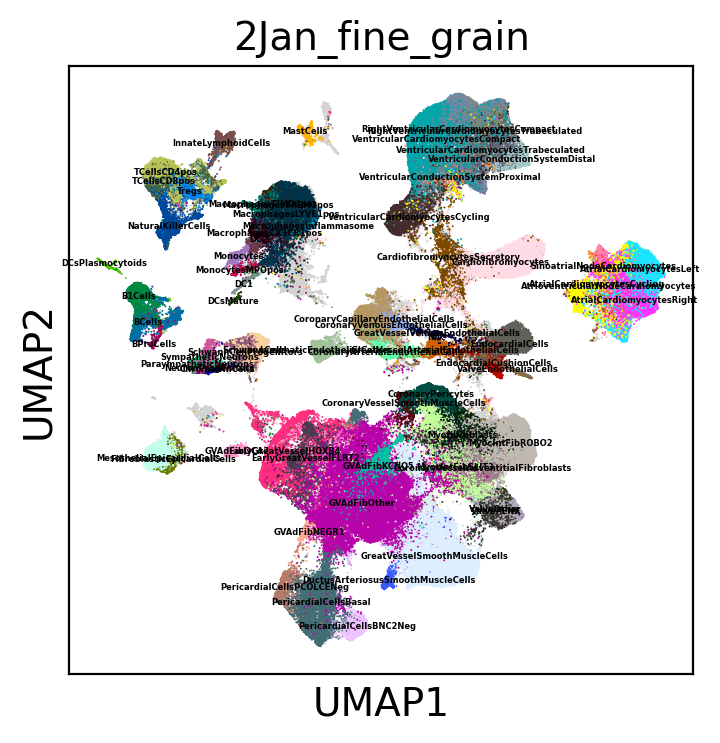

In [20]:
sc.pl.umap(adata, color=['2Jan_fine_grain'], size=2, wspace=0.1, legend_loc='on data', legend_fontsize=3)

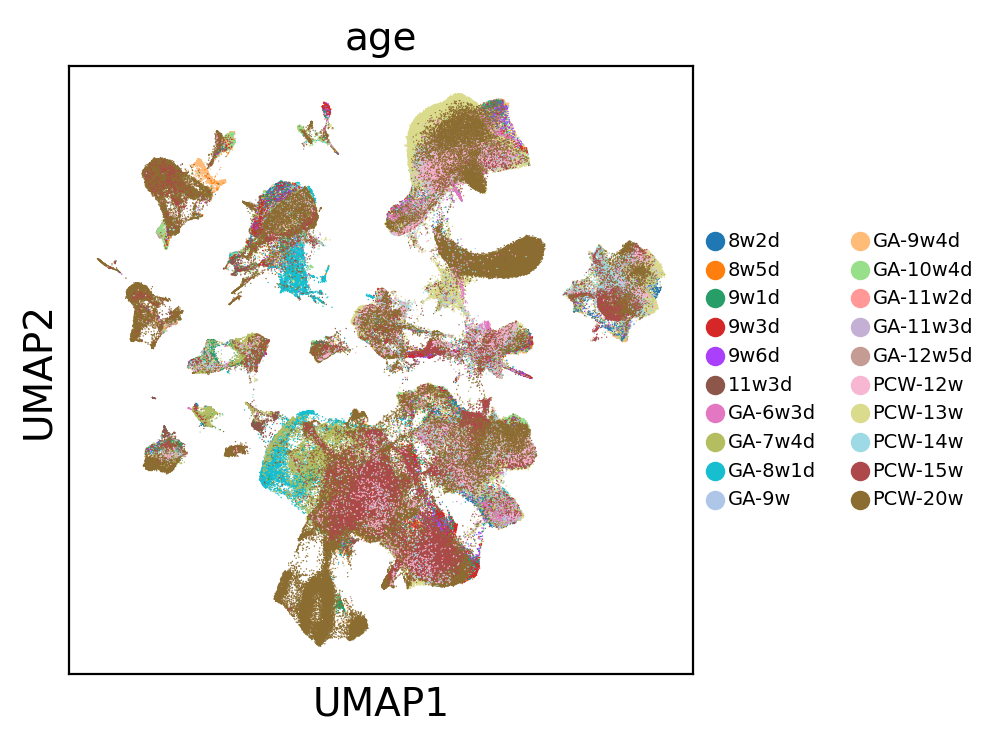

In [21]:
sc.pl.umap(adata, color=['age'], size=1, legend_fontsize=7)

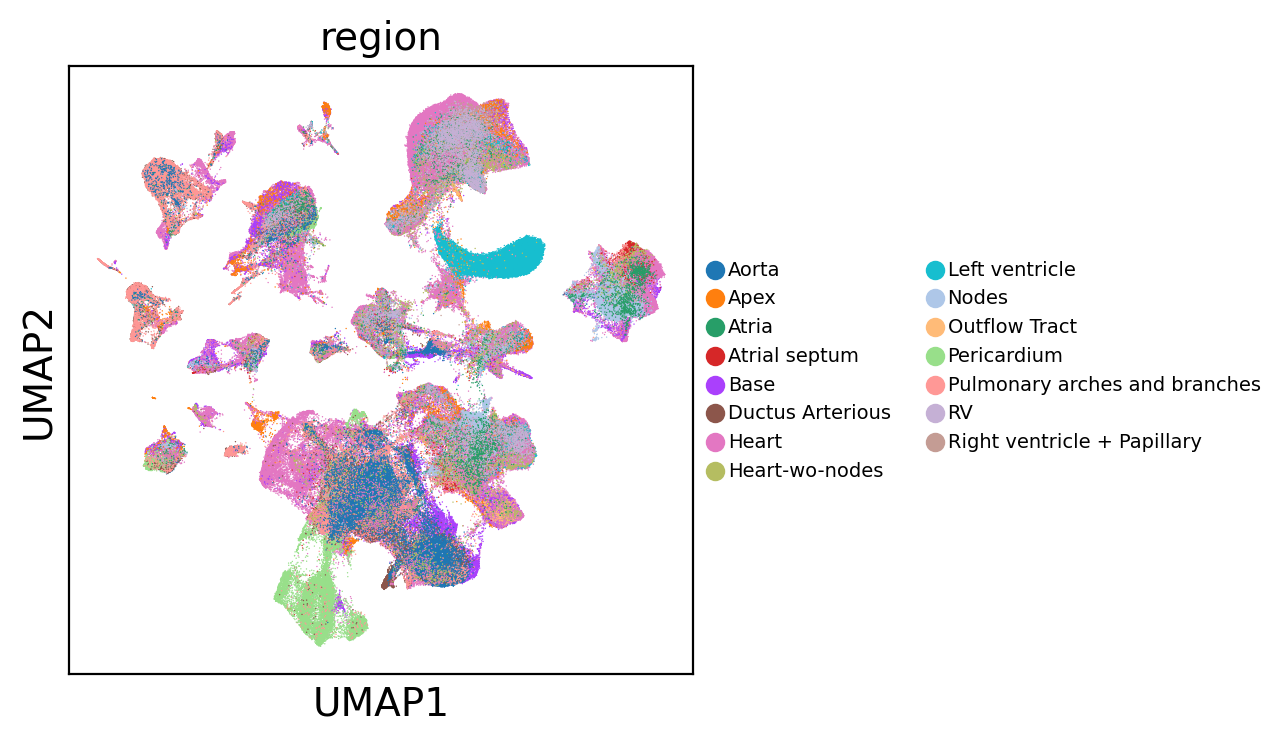

In [22]:
sc.pl.umap(adata, color=['region'], size=1, legend_fontsize=7)

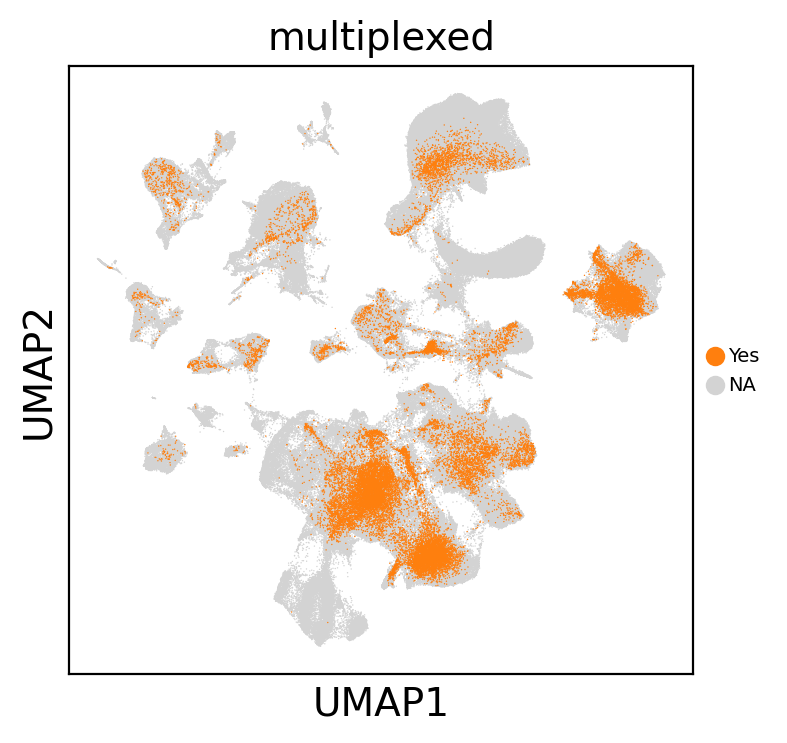

In [23]:
sc.pl.umap(adata, color=['multiplexed'], groups='Yes', size=1, legend_fontsize=7)

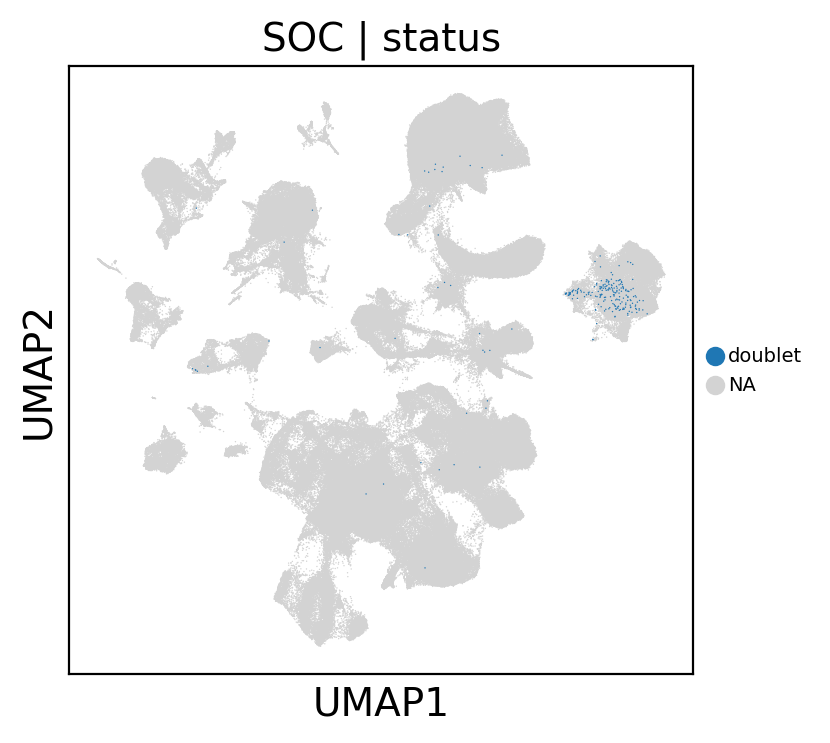

In [24]:
sc.pl.umap(adata, color=['SOC | status'], groups='doublet', size=1, legend_fontsize=7)

In [ ]:
sc.pl.umap(adata, color=['region'], groups=['Pericardium','Aorta','Left ventricle','Pulmonary artery + main bronchus'], size=2, legend_loc='on data', legend_fontsize=5)

In [ ]:
sc.pl.umap(adata, color=['age'], groups=['PCW-12w','PCW-13w','PCW-14w','PCW-15w','PCW-20w'], size=2, legend_loc='on data', legend_fontsize=5, ncols=5)

In [ ]:
sc.pl.umap(adata, color=['donor','cell_or_nuclei','kit_10x','facility'], size=0.5, wspace=0.6)

In [ ]:
sc.settings.set_figure_params(dpi=200, color_map = 'RdPu',)
sc.pl.umap(adata, color=['n_genes', 'n_genes_by_counts',
       'total_counts','pct_counts_mt','pct_counts_ribo'], size=2, wspace=0.2, ncols=5)

In [ ]:
sc.pl.umap(adata, color=['scrublet_score','cluster_scrublet_score','doublet_pval','doublet_bh_pval'], size=2, wspace=0.2, ncols=5)

## Proportions

In [ ]:
plt.rcParams['figure.figsize'] = 5,5
tmp = pd.crosstab(adata.obs['kit_10x'], adata.obs['age'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

## Reconstruct raw counts

In [11]:
adata_raw=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_raw.h5ad')
print(adata_raw)

adata_raw=anndata.AnnData(X=adata_raw[adata.obs_names,:].X,
                      obs=adata.obs, # from annotated data
                      var=adata_raw.var,
                      obsm=adata.obsm, # from annotated data
                      obsp=adata.obsp # from annotated data
                               )
print(adata_raw)

AnnData object with n_obs × n_vars = 372801 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    obsm: 'latent_gene_encoding'
AnnData object with n_obs × n_vars = 372801 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_typ

In [12]:
### add CD45 sorting key ###
cd45 = pd.read_csv('/nfs/team205/heart/anndata_objects/Foetal/metadata/5prime_FACS.csv')
cd45.rename(columns={'FACS gate':'FACSgate'},inplace=True)
print(cd45)

adata_raw.obs = adata_raw.obs.reset_index().merge(cd45,how='left',on='sangerID').set_index('barcode')
adata_raw.obs[['FACSgate','sangerID']].value_counts()

            sangerID FACSgate
0  BHF_F_Hea10402917  CD45pos
1  BHF_F_Hea10402918  CD45neg
2  BHF_F_Hea11192323  CD45pos
3  BHF_F_Hea11192324  CD45neg
4  BHF_F_Hea11192325  CD45pos
5  BHF_F_Hea11192326  CD45neg
6  BHF_F_Hea11192327  CD45pos
7  BHF_F_Hea11192328  CD45neg


FACSgate  sangerID         
CD45neg   BHF_F_Hea11192328    12056
          BHF_F_Hea11192324    10553
          BHF_F_Hea11192326     9876
CD45pos   BHF_F_Hea11192325     7512
          BHF_F_Hea11192327     5865
CD45neg   BHF_F_Hea10402918     4340
CD45pos   BHF_F_Hea11192323     3418
          BHF_F_Hea10402917     2227
dtype: int64

In [13]:
adata_raw.obs['FACSgate'].unique()

array(['CD45pos', 'CD45neg', nan], dtype=object)

## Save

In [14]:
adata_raw.write('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_post-scVI_raw.h5ad')
adata_raw

... storing 'sangerID' as categorical
... storing 'FACSgate' as categorical


AnnData object with n_obs × n_vars = 372801 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', '_scvi_labels', '2Jan_coarse_grain', '2Jan_mid_grain', '2Jan_fine_grain', 'leiden_scVI', 'FACSgate'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    obsm: 'X_scVI', '_scvi_extra_continuous', 'latent_gene_encoding', 'X_umap

In [4]:
adata_raw=sc.read_h5ad('/nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_post-scVI_raw.h5ad')
adata_raw

AnnData object with n_obs × n_vars = 372801 × 36601
    obs: 'latent_RT_efficiency', 'latent_cell_probability', 'latent_scale', 'sangerID', 'combinedID', 'donor', 'donor_type', 'region', 'region_finest', 'age', 'gender', 'facility', 'cell_or_nuclei', 'modality', 'kit_10x', 'flushed', 'scrublet_score', 'scrublet_leiden', 'cluster_scrublet_score', 'doublet_pval', 'doublet_bh_pval', 'n_genes', 'n_counts', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'HB_score', 'donor_by_library-prep', 'multiplexed', 'SOC | status', 'SOC | log_prob_singleton', 'SOC | log_prob_doublet', 'batch_key', '_scvi_batch', '_scvi_labels', '2Jan_coarse_grain', '2Jan_mid_grain', '2Jan_fine_grain', 'leiden_scVI', 'FACSgate'
    var: 'gene_name_scRNA-0', 'gene_name_multiome-1'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_continuous', 'latent_gene_encoding

In [10]:
adata_raw[adata_raw.obs['2Jan_coarse_grain']=='Leukocytes'].obs['age'].value_counts()

PCW-20w     21354
GA-10w4d     5353
GA-9w4d      3025
11w3d        1987
PCW-13w      1728
GA-12w5d     1627
9w6d          890
9w3d          604
8w5d          520
GA-7w4d       482
8w2d          398
9w1d          376
GA-9w         359
GA-11w2d      101
GA-11w3d       62
GA-6w3d        40
Name: age, dtype: int64

In [8]:
adata_raw.obs['2Jan_coarse_grain'].value_counts()

Mesenchymal       128528
Cardiomyocytes     96591
Leukocytes         38906
Endothelium        20122
Neural              5998
Epicardium          3879
Name: 2Jan_coarse_grain, dtype: int64

In [13]:
set(adata_raw.obs['cell_or_nuclei'])

{'Cell', 'Nuclei'}

In [19]:
import sys
sys.getsizeof(adata_raw)

120335786

In [ ]:
# rclone to gdrive
rclone copy /nfs/team205/heart/anndata_objects/Foetal/RNA_foetal_post-scVI_raw.h5ad \
gdrive:JamesC_Kazumasa/Foetal_Heart/SanjayShinha/toSinhalab/anndata/

In [ ]:
adata_raw.obs['region'].value_counts()

In [ ]:
sc.pl.umap(adata_raw, color=['region'], groups=['Pericardium','Aorta','Left ventricle','Pulmonary artery  + main bronchus'], size=2,legend_fontsize=7)

In [ ]:
sc.pl.umap(adata_raw, color=['region'], groups=['Pericardium'], size=2,legend_fontsize=7)

In [ ]:
sc.pl.umap(adata_raw[adata_raw.obs['region']!='Pulmonary artery  + main bronchus'], 
           color=['previous_mid_grain'], size=2,legend_fontsize=7)

In [ ]:
adata_raw[adata_raw.obs['age']=='PCW-20w']

In [ ]:
ad = adata_raw[adata_raw.obs['age']=='PCW-20w']

plt.rcParams['figure.figsize'] = 5,5
tmp = pd.crosstab(ad.obs['previous_mid_grain'], ad.obs['region'], normalize='index')
# tmp.plot.bar().legend(loc=1)
ax = tmp.plot.bar(stacked=True,width=0.7)
ax.grid(False)
ax.set_ylabel('proportion')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.plot()

In [ ]:
# filter and lognormalised
sc.pp.filter_genes(adata_raw, min_cells=3)
sc.pp.normalize_total(adata_raw, target_sum=1e4)
sc.pp.log1p(adata_raw)

In [ ]:
# set gene name as var_names 
adata_raw.var['gene_id']=adata_raw.var_names.copy()
adata_raw.var.set_index('gene_name_multiome-1',inplace=True)
adata_raw.var_names=adata_raw.var_names.astype('str')
adata_raw.var_names_make_unique()

In [ ]:
sc.pl.umap(adata_raw, 
           color=['FOXP3','CD4','CD8A','CD3E'], size=2,legend_fontsize=7)

In [ ]:
for reg in set(adata_raw.obs['region']):
    print(reg)
    sc.pl.umap(adata_raw[adata_raw.obs['region']==reg], 
           color=['FOXP3','CD4','CD8A','CD3E'], size=2,legend_fontsize=7)

In [ ]:
set(adata_raw.obs['region'])

In [ ]:
pd.crosstab(ad.obs['previous_mid_grain'], ad.obs['region'], normalize='index')

In [ ]:
tmp 